# Maximum-radius orbit transfer

Example taken from Sec 2.5 in Bryson & Ho (also used as an example in [this](https://arc.aiaa.org/doi/10.2514/1.A35138) paper).

$$
\max_{\phi(t), \mathbf{x}(t)} r(t_f)
$$

subject to the dynamic constraints

$$
\begin{gather*}
\dot{r} = u \\
\dot{u} = \frac{v^2}{r} - \frac{\mu}{r^2} + \frac{T \sin \phi }{m_0 - |\dot{m}|t} \\
\dot{v} = -\frac{uv}{r} + \frac{T \cos \phi }{m_0 - |\dot{m}|t}
\end{gather*}
$$

and boundary conditions

$$
\begin{gather*}
r(0) = r_0 \\ 
u(0) = 0 \\
v(0) = \sqrt{\frac{\mu}{r_0}} \\
u(t_f) = 0 \\
v(t_f) = \sqrt{\frac{\mu}{r(t_f)}},
\end{gather*}
$$

where $r$ is the radius of the orbit, $u$ and $v$ are the radial and tangential components of velocity, respectively, $m$ is the mass of the spacecraft, $\dot{m}$ is the (constant) fuel consumption rate, $\phi$ is the thrust angle, and $\mu$ is the gravitational constant of the central body.

The original parameters of the problem were $T = 0.85$ lbs, $m = 10,000$ lbs, $\dot{m} = 12.9$ lb/day.  In normalized units, we can instead use $\mu = 1$, $T = 0.1405$, $r_0 = 1$, $m_0 = 1$, $\dot{m} = -0.07487$, with fixed end time $t_f = 3.32$ (corresponding to about 193 days).

In [1]:
import numpy as np

from archimedes.experimental import coco as cc
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
mu = 1.0
r0 = 1.0
T = 0.1405
m0 = 1.0
m_dot = -0.07487
tf = 3.32

nx, nu = 4, 1
x0 = np.array([r0, 0.0, 0.0, np.sqrt(mu / r0)])
t0, tf = 0.0, 3.32


def j(t, x, phi, p):
    return 0.0


def f(t, x, phi, p):
    r, θ, u, v = x
    phi = phi[0]  # Remove extra leading dimension
    f_sp = T / (m0 + m_dot * t)
    return np.array(
        [
            u,
            v / r,
            v**2 / r - mu / r**2 + f_sp * np.sin(phi),
            -u * v / r + f_sp * np.cos(phi),
        ],
        like=x,
    )


def cost(x0, t0, xf, tf, q, p):
    rf, θf, uf, vf = xf
    return -rf


# Discretize the domain
N = [20]
knots = []
domain = cc.RadauFiniteElements(N=N, knots=knots)


# Require the terminal orbit to be circular
def terminal_constraint(boundary_data):
    rf, θf, uf, vf = boundary_data.xf
    return np.array(
        [
            uf,
            vf - np.sqrt(mu / rf),
        ],
        like=boundary_data.xf,
    )


boundary_conditions = [
    cc.start_time(t0),
    cc.end_time(tf),
    cc.initial_condition(x0),
    cc.Constraint(terminal_constraint, nc=2),
]

path_constraints = [cc.control_bounds([0.0], [2 * np.pi])]

# Define the optimal control problem
ocp = cc.OptimalControlProblem(
    nx=nx,
    nu=nu,
    ode=f,
    quad=j,
    cost=cost,
    boundary_constraints=boundary_conditions,
    path_constraints=path_constraints,
)

# Linearly interpolate initial guess
rf_guess = 1.5
xf_guess = np.array([rf_guess, np.pi, 0.0, np.sqrt(mu / rf_guess)])


def x_guess(t):
    return x0 + (t - t0) * (xf_guess - x0) / (tf - t0)


def u_guess(t):
    return np.pi * (1.0 + np.tanh(5 * (t - tf / 2)))


# Solve the optimal control problem
sol = ocp.solve(
    domain,
    t_guess=(t0, tf),
    x_guess=x_guess,
    u_guess=u_guess,
)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2029
Number of nonzeros in inequality constraint Jacobian.:       22
Number of nonzeros in Lagrangian Hessian.............:      284

Total number of variables............................:      106
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       88
Total number of inequality c

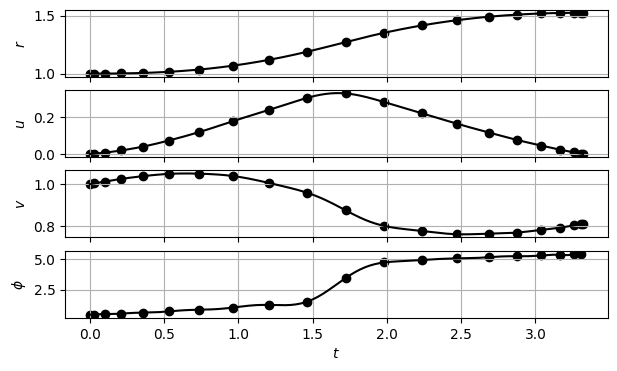

In [3]:
import matplotlib.pyplot as plt

t_plt = np.linspace(t0, tf, 200)
x_plt = sol.x(t_plt)
u_plt = sol.u(t_plt)

fig, ax = plt.subplots(4, 1, figsize=(7, 4), sharex=True)
ax[0].scatter(sol.tp, sol.xp[:, 0], c="k")
ax[0].plot(t_plt, x_plt[:, 0], c="k")
ax[0].grid()
ax[0].set_ylabel(r"$r$")
ax[1].scatter(sol.tp, sol.xp[:, 2], c="k")
ax[1].plot(t_plt, x_plt[:, 2], c="k")
ax[1].grid()
ax[1].set_ylabel(r"$u$")
ax[2].scatter(sol.tp, sol.xp[:, 3], c="k")
ax[2].plot(t_plt, x_plt[:, 3], c="k")
ax[2].grid()
ax[2].set_ylabel(r"$v$")
ax[3].scatter(sol.tp[:-1], sol.up, c="k")
ax[3].plot(t_plt, u_plt, c="k")
ax[3].grid()
ax[3].set_ylabel(r"$\phi$")
ax[3].set_xlabel(r"$t$")

plt.show()

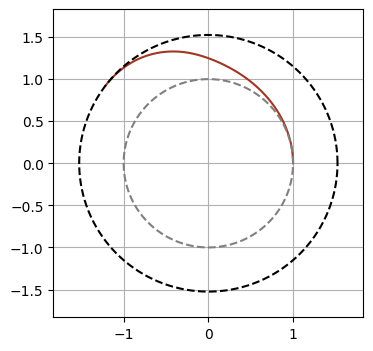

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

r, θ = x_plt[:, 0], x_plt[:, 1]
x, y = r * np.cos(θ), r * np.sin(θ)

rf = r[-1]
r0 = r[0]
rmax = max(r)

ax.plot(x, y, c="xkcd:brick")

θ = np.linspace(0, 2 * np.pi, 1000)
ax.plot(r0 * np.cos(θ), r0 * np.sin(θ), c="grey", ls="--")
ax.plot(rf * np.cos(θ), rf * np.sin(θ), c="k", ls="--")

ax.set_xlim([-1.2 * rmax, 1.2 * rmax])
ax.set_ylim([-1.2 * rmax, 1.2 * rmax])
ax.grid()
plt.show()

### Mesh refinement

In [5]:
# Initial solution
domain = cc.RadauFiniteElements(N=[20], knots=[])
sol = ocp.solve(
    domain,
    t_guess=(t0, tf),
    x_guess=x_guess,
    u_guess=u_guess,
    ipopt={"print_level": 0},
    print_time=0,
)

# Refine mesh
max_iter = 50
eps = 1e-4
for i in range(max_iter):
    print(f"\n*** Iteration {i + 1} ***")
    residuals = cc.midpoint_residuals(ocp, domain, sol)
    converged, domain = cc.refine_mesh_bisection(
        domain, residuals, eps=eps, incr=10, verbose=True
    )
    sol = ocp.solve(
        domain,
        t_guess=(sol.t0, sol.tf),
        x_guess=sol.x,
        u_guess=sol.u,
        ipopt={"print_level": 0},
        print_time=0,
    )

    if converged:
        break

print(f"Finished after {i + 1} iterations. Knots: {domain.knots}")


*** Iteration 1 ***
Element 0: residual (max/avg) = 7.48e-02/3.14e-02, max scaled = 2.38e+00
New domain: [30], knots=[]

*** Iteration 2 ***
Element 0: residual (max/avg) = 4.52e-02/1.47e-02, max scaled = 3.07e+00
	Splitting at τ=0.0
New domain: [10, 10], knots=[np.float64(0.0)]

*** Iteration 3 ***
Element 0: residual (max/avg) = 1.69e-03/4.76e-04, max scaled = 3.55e+00
	Splitting at τ=-0.5
Element 1: residual (max/avg) = 9.76e-03/5.68e-03, max scaled = 1.72e+00
New domain: [10, 10, 20], knots=[np.float64(-0.5), np.float64(0.0)]

*** Iteration 4 ***
Element 0: residual (max/avg) = 1.19e-09/5.35e-10, max scaled = 2.22e+00
	Converged
Element 1: residual (max/avg) = 3.05e-04/9.01e-05, max scaled = 3.38e+00
	Splitting at τ=-0.25
Element 2: residual (max/avg) = 1.08e-03/5.41e-04, max scaled = 2.00e+00
New domain: [10, 10, 10, 30], knots=[np.float64(-0.5), np.float64(-0.25), np.float64(0.0)]

*** Iteration 5 ***
Element 0: residual (max/avg) = 1.19e-09/5.35e-10, max scaled = 2.22e+00
	Conv

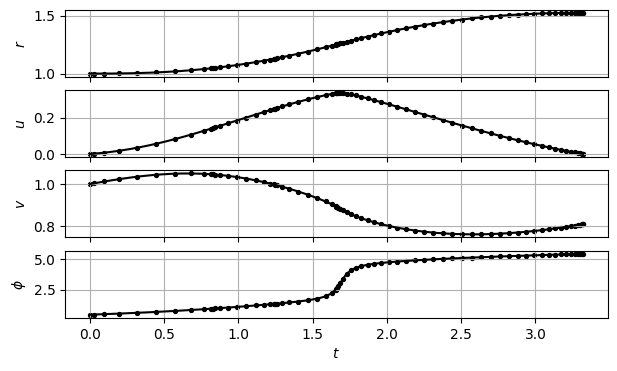

In [6]:
import matplotlib.pyplot as plt

t_plt = np.linspace(t0, tf, 200)
x_plt = sol.x(t_plt)
u_plt = sol.u(t_plt)

fig, ax = plt.subplots(4, 1, figsize=(7, 4), sharex=True)
ax[0].scatter(sol.tp, sol.xp[:, 0], c="k", s=8)
ax[0].plot(t_plt, x_plt[:, 0], c="k")
ax[0].grid()
ax[0].set_ylabel(r"$r$")
ax[1].scatter(sol.tp, sol.xp[:, 2], c="k", s=8)
ax[1].plot(t_plt, x_plt[:, 2], c="k")
ax[1].grid()
ax[1].set_ylabel(r"$u$")
ax[2].scatter(sol.tp, sol.xp[:, 3], c="k", s=8)
ax[2].plot(t_plt, x_plt[:, 3], c="k")
ax[2].grid()
ax[2].set_ylabel(r"$v$")
ax[3].scatter(sol.tp[:-1], sol.up, c="k", s=8)
ax[3].plot(t_plt, u_plt, c="k")
ax[3].grid()
ax[3].set_ylabel(r"$\phi$")
ax[3].set_xlabel(r"$t$")

plt.show()

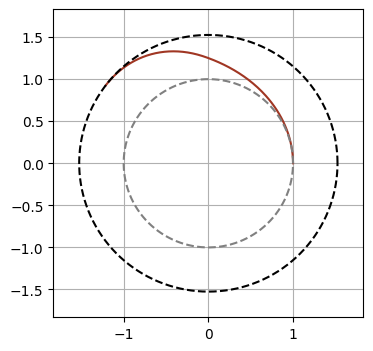

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

r, θ = x_plt[:, 0], x_plt[:, 1]
x, y = r * np.cos(θ), r * np.sin(θ)

rf = r[-1]
r0 = r[0]
rmax = max(r)

ax.plot(x, y, c="xkcd:brick")

θ = np.linspace(0, 2 * np.pi, 1000)
ax.plot(r0 * np.cos(θ), r0 * np.sin(θ), c="grey", ls="--")
ax.plot(rf * np.cos(θ), rf * np.sin(θ), c="k", ls="--")

ax.set_xlim([-1.2 * rmax, 1.2 * rmax])
ax.set_ylim([-1.2 * rmax, 1.2 * rmax])
ax.grid()
plt.show()